# Movie Industry Analysis for Novel Title Direction for Microsoft Movie Studio

## Overview
This project seeks to identify the success parameters of the recently released movie titles for consulting and directing the creation of a novel title for the client: Microsoft Movie Studios.

## Business Problem

![img](https://img-prod-cms-rt-microsoft-com.akamaized.net/cms/api/am/imageFileData/RE2qVsJ?ver=3f74)

<br>
Microsoft sees all the big companies creating original video content, and they want to get in on the fun. They have decided to create a new movie studio, but the problem is they don’t know anything about creating movies. They have hired you to help them better understand the movie industry. Your team is charged with exploring what type of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of Microsoft's new movie studio can use to help decide what type of films to create.


## Structure

The data set can be found in `/data` folder.
<br>
The intial data has been obtained from following sources. 

- Box Office Mojo (prefix: bom)
- IMDB (prefix: imdb)
- Rotten Tomatoes (prefix: rt)
- TheMoiveDB.org (prefix: tmdb)
- TheNumbers.com (prefix: tn)

The data has been filtered and merged into few datasets.

- i_tn_profit_clean.csv
    - Merged IMDB and TheNumbers.com data with movies that only made profit in either domestic or worldwide market
- imdb.title_rating_summary.csv
    - Merged IMDB table of ratings and movie info summary
    
All plots and locally saved images can be found in `/images` folder.

## Big Questions

- How should the movie be budgeted?
- What genres should the movie plot be centered around?
- When should the movie be released?

## Analysis Focus

1. This analysis focuses on wholistic data available from past decade (2010 and beyond)
2. This analysis focuses on movies that has made profit in either domestic or worldwide market

## Contributors
[Cierra Andaur](https://github.com/cierra4prez)
<br>
[Yung Han Jeong](https://github.com/yunghanjeong)

***

<h2 align="center">Data Analysis</h2>

***

### Library Import

In [13]:
import os
import pandas as pd
import numpy as np
import src.tools as tl
import matplotlib.pyplot as plt
%matplotlib inline

### ALL DATA IMPORT 

In [14]:
#----------------Box Office Mojo------------------------------#
bom_df = pd.read_csv("data/bom.movie_gross.csv.gz") #title, studio, domestic gross(float), foreign_gross(object), year(int)

#-----------------------IMDB----------------------------#
i_basic_df = pd.read_csv("data/imdb.name.basics.csv.gz") #people basic info
i_aka_df = pd.read_csv("data/imdb.title.akas.csv.gz") #movie title alternative/foreign name
i_title_basic_df = pd.read_csv("data/imdb.title.basics.csv.gz") #movie title basic info
i_crew_df = pd.read_csv("data/imdb.title.crew.csv.gz") #crew info by nconst
i_principal_df = pd.read_csv("data/imdb.title.principals.csv.gz") #principal people of the movie
i_rating_df = pd.read_csv("data/imdb.title.ratings.csv.gz") #rating and number of votes by tconst


#-----------------------Rotten Tomato---------------------------#
#Shoutout to Tim Hintz and Eric Roberts!
rt_info_df = pd.read_csv("data/rt.movie_info.tsv.gz", delimiter = "\t", encoding='ISO-8859-1' ) #reviews and info
rt_review_df = pd.read_csv("data/rt.reviews.tsv.gz", delimiter = "\t", encoding='ISO-8859-1' ) #reviews by critics

#--------------------The Movie Database -------------------#
tmdb_df = pd.read_csv("data/tmdb.movies.csv.gz") #summary of movie info

#-------------------The Numbers---------------------------------#
tn_df = pd.read_csv("data/tn.movie_budgets.csv.gz") #movie release date, title, budget, gross
tn_profit_df = pd.read_csv("data/tn.profit_movie_budgets.csv", index_col = 0) #filterd dataset of above with movies that only made profit

#---------------------Merged Datasets---------------------------#
i_sum_df = pd.read_csv("data/imdb.title_rating_summary.csv", index_col = 0)
i_tn_profit_df = pd.read_csv("data/i_tn_profit_clean.csv", index_col = 0)


print("All DataFrame Loaded")

All DataFrame Loaded


***

<h2 align="center">Profitability and Trends of Genre From 2010-2018</h2>

This analysis will utilize `i_tn_profit_clean.csv` which is a combined and cleaned dataset of IMDB and TheNumbers.com data. The genres column IMDB data contains the up to 3 genre tags per title. That column will be filtered through `unpack_genre` method from `src/tools.py` to obtain a dictionary which contains key:value pairs of genre:frequency. The genres columns will also be expanded to separate each tags as separate genre columns (genre1, genre2, genre3) for further grouped analysis. 


### Questions
- Which genre performs overall the best?
- Which genre performs best per title?
- Are there a growing or diminishing trend in genres?



#### Genre Performance 
Get each genres frequency in genres column separated into each tag and evaluate gross profit and normalized profit of each genre tags

In [15]:
genre_i_tn = i_tn_profit_df.copy()

In [16]:
#get unique genre tag set 
profit_group_genres = tl.unpack_genre(list(genre_i_tn.genres.dropna()))
profit_group_genres

{'western': 4,
 'musical': 5,
 'war': 8,
 'documentary': 21,
 'sport': 22,
 'history': 25,
 'music': 36,
 'family': 74,
 'biography': 88,
 'animation': 93,
 'mystery': 93,
 'fantasy': 96,
 'sci-fi': 100,
 'horror': 117,
 'romance': 141,
 'crime': 153,
 'thriller': 180,
 'adventure': 298,
 'action': 325,
 'comedy': 393,
 'drama': 475}

As can be seen above western, musical, and war genres do not contain significant amounts of data for good comparison. These columsn will be dropped for further analysis in the future.
<br>
<br>
#### Expanding Genres Columns

In [17]:
genre_i_tn[["genre1", "genre2", "genre3"]] = genre_i_tn.genres.str.split(",", expand = True)

In [18]:
#sanity check
#genre_i_tn.head()

In [19]:
genre1_profit = genre_i_tn.groupby("genre1").sum()[["domestic_profit", "worldwide_profit"]]
genre2_profit = genre_i_tn.groupby("genre2").sum()[["domestic_profit", "worldwide_profit"]]
genre3_profit = genre_i_tn.groupby("genre3").sum()[["domestic_profit", "worldwide_profit"]]

Obtain total profit per genre using calculation above

In [20]:
genre_total = genre1_profit.add(genre2_profit, fill_value=0).add(genre3_profit, fill_value =0)

In [21]:
#sanity check
#genre_total.head()

Drop low population data for more insightful analysis

In [22]:
genre_total.drop(["Musical", "Western", "War"], inplace = True)

genre_count dataframe can be created from the dictionary above for normalizing the total profit values

In [23]:
#Create Genre Count from dictionary above and reformat index
genre_count = pd.Series(profit_group_genres)
genre_count = genre_count.reset_index()
genre_count["index"] = genre_count["index"].apply(lambda txt: txt.title()) #titlize the output 
genre_count.set_index("index", inplace = True)
genre_count.sort_index(inplace = True)
genre_count.drop(["Musical", "Western", "War"], inplace = True) #drop same columns as above

In [24]:
#normalize data
genre_total["norm_domestic"] = genre_total["domestic_profit"]/genre_count[0]
genre_total["norm_worldwide"] = genre_total["worldwide_profit"]/genre_count[0]

#### Plot Total Gross and Normalize Data

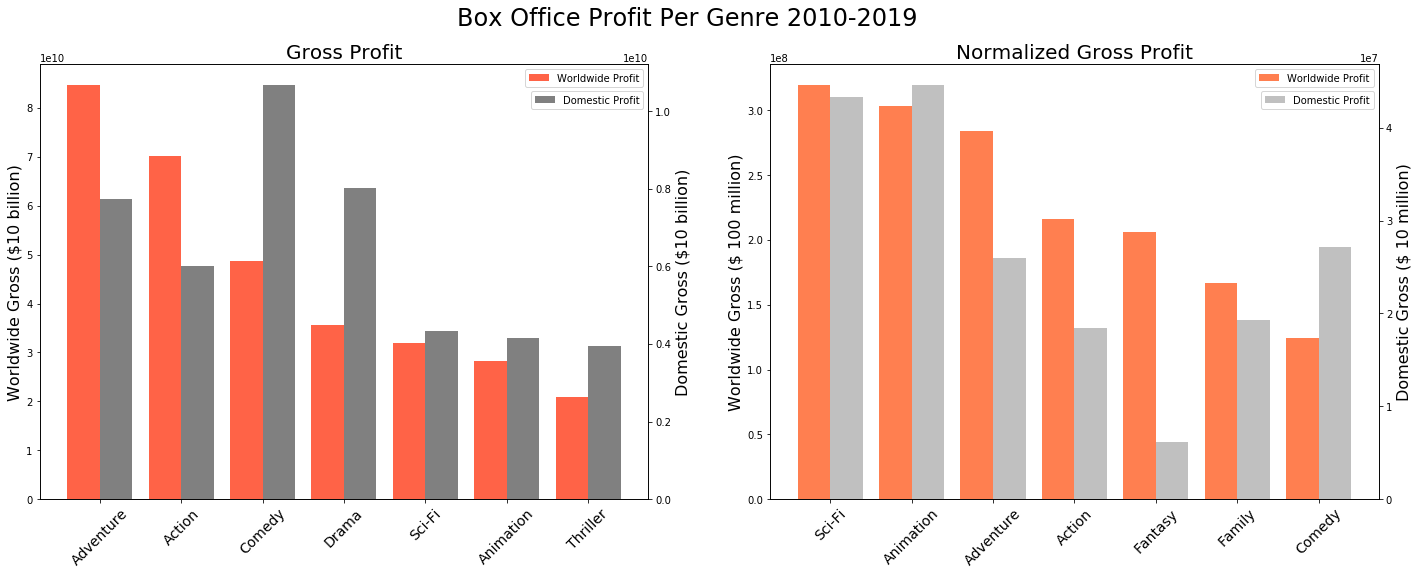

In [25]:
#Set Figure Size
plt.figure(figsize=(24,8))

#Set top data slicing value total number of top ranks to plot
graphrank = 7 #must be less than or equal to the length of the genre_total


#------------------------GENRE TOTAL PLOT------------------------#
#sort and slice before plotting
plot_total = genre_total.sort_values("worldwide_profit", ascending = False)
plot_total = plot_total[:graphrank]

#set first bar graph x positions and width
ax = plt.subplot(1,2,1) #set figure position
ax2 = ax.twinx() #set twin x axis
xpos = np.array(range(0,len(plot_total))) #xpos for barset
width = 0.4 #set bar width for offset

#bar plot both domestic and worldwide gross based on genre
domestic = ax2.bar(xpos+width/2, plot_total["domestic_profit"].values, 
                   width, label = "Domestic Profit", color = "grey")
worldwide = ax.bar(xpos-width/2, plot_total["worldwide_profit"].values, 
                   width, label = "Worldwide Profit", color = "tomato")

#set x axis markers
ax.set_xticks(xpos);
ax.set_xticklabels(plot_total.index, rotation = 45, size=14);

#set labels
ax.set_ylabel("Worldwide Gross ($10 billion)", size=16);
ax2.set_ylabel("Domestic Gross ($10 billion)", size=16);
ax.set_title("Gross Profit", size=20)

#set legend
ax.legend(bbox_to_anchor=(0,0,1,1), loc="upper right")
ax2.legend(bbox_to_anchor=(0,-.05,1,1), loc="upper right")

#-----------------NORMALIZED GENRE PROFIT PLOT----------------------------#
#sort and slice before plotting
plot_norm = genre_total.sort_values("norm_worldwide", ascending = False)
plot_norm = plot_norm[:graphrank]

#set second plot x positions
ax3 = plt.subplot(1,2,2) #set figure position
ax4 = ax3.twinx() #set twin x axis
xpos = np.array(range(0,len(plot_norm))) #xpos for barset
width = 0.4 #set bar width for offset



#bar plot both domestic and worldwide gross based on genre
domestic = ax4.bar(xpos+width/2, plot_norm["norm_domestic"].values, 
                   width, label = "Domestic Profit", color = "silver")
worldwide = ax3.bar(xpos-width/2, plot_norm["norm_worldwide"].values, 
                    width, label = "Worldwide Profit", color = "coral")

#set x axis markers
ax3.set_xticks(xpos);
ax3.set_xticklabels(plot_norm.index, rotation = 45, size=14);

#set labels
ax3.set_ylabel("Worldwide Gross ($ 100 million)", size=16);
ax4.set_ylabel("Domestic Gross ($ 10 million)", size=16);
ax3.set_title("Normalized Gross Profit", size=20)

#set legend
ax3.legend(bbox_to_anchor=(0,0,1,1), loc="upper right")
ax4.legend(bbox_to_anchor=(0,-.05,1,1), loc="upper right")
plt.suptitle("Box Office Profit Per Genre 2010-2019", size = 24)

#--------------------------SAVE IMAGE--------------------------#
#Please only uncomment if you wish to save the image
#plt.savefig("images/norm_gross_sbs_profit_genre.png")

plt.show()

As can be seen above, Sci-Fi and Animation takes the top place in normalized profit per genre with Adventure and Action following behind. Comey and Drama falls quickly behind in Worldwide market, but still maintains strong domestic presence as expected form earlier analysis. Fantasy genre gained considerable ranking, but this is most likely due to recent huge success in fantasy films such as Harry Potter. 

#### Genre trend from 2010-2018
Genre Trend will be analyzed only between 2010-2018, since 2019 has far less population than rest of the group

In [27]:
#Initialize empty dataframe to store results
genre_yearly_count = pd.DataFrame()
#get range of years from the dataset to analyze
year_range = sorted(list(i_tn_profit_df.release_year.unique()))

#for every year in the year range
for year in year_range:
    #get each genre tag's appearance per genre columns
    yearly_count1 = genre_i_tn[genre_i_tn["release_year"] == year].groupby("genre1")["primary_title"].nunique()
    yearly_count2 = genre_i_tn[genre_i_tn["release_year"] == year].groupby("genre2")["primary_title"].nunique()
    yearly_count3 = genre_i_tn[genre_i_tn["release_year"] == year].groupby("genre3")["primary_title"].nunique()
    
    #add up the results for total genre appearance of that year. Use 0 for unavailable data
    yearly_count = yearly_count1.add(yearly_count2, fill_value = 0).add(yearly_count3, fill_value = 0)
    
    #concatenate the results before looping again
    genre_yearly_count = pd.concat([genre_yearly_count, yearly_count], axis=1, sort=True)

#set column names to the year range
genre_yearly_count.columns = year_range
#drop 2019 due to incomplete/low data
genre_yearly_count.drop(columns=2019, inplace = True)
#fill NaN values with 0 for plotting
genre_yearly_count.fillna(0, inplace = True)

Transposing the data to flip the index and columns, which will make more sense for visualization. Also dropping the 3 outlier genres: Musical, War, and Western. This results in 18 total genres to analyze. 

In [28]:
genre_yearly_count = genre_yearly_count.transpose().drop(columns = ["Musical", "War","Western"])

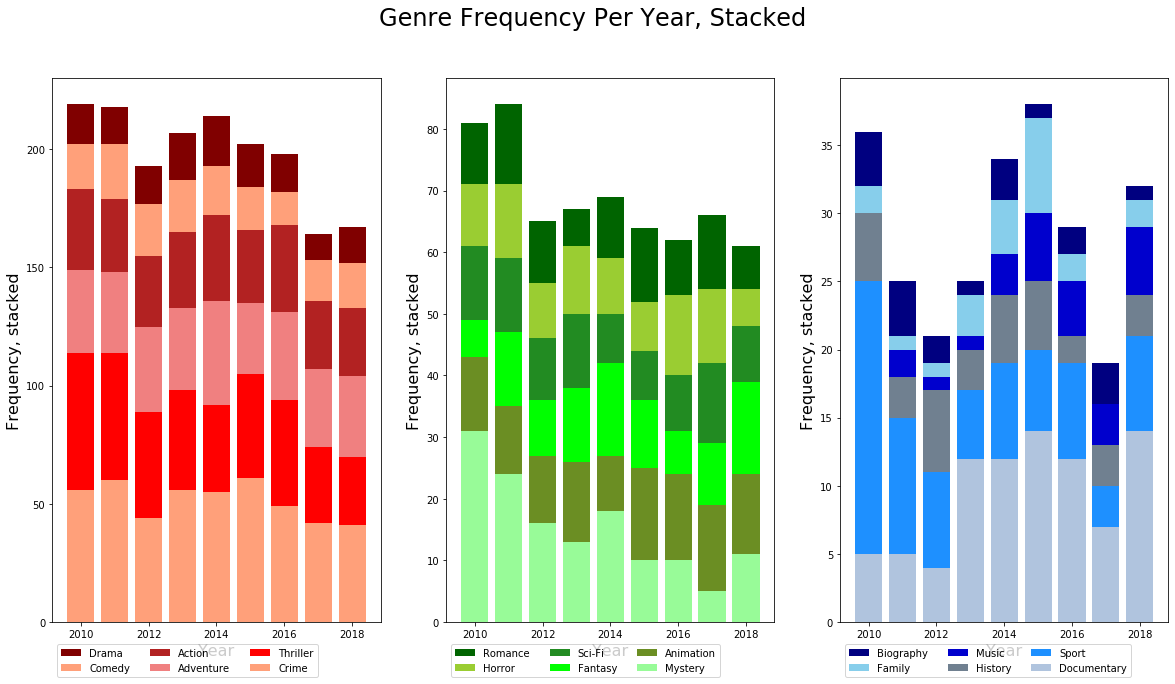

In [29]:
#set figure size
plt.figure(figsize=(20,10))

#rank each genre to plot, defined number of subplots and get division count
ranked_genre = genre_yearly_count.mean().sort_values(ascending = False).index


#------------------------------first subplot----------------------------------------#
ax = plt.subplot(1,3,1)
axdata = genre_yearly_count[ranked_genre[:6]]
axlabel = list(axdata.columns)

#prettifying
axcolor = ["lightsalmon","red","lightcoral","firebrick","lightsalmon","maroon"]

#this list is used for indexing the data total backwards to draw stacked bar-graph
barrange1 = list(range(0,len(axdata.columns)))[::-1]

#use for loop to label each line
for idx, data in zip(barrange1,axdata):
    plotheight = axdata.iloc[:,:idx+1].sum(axis=1)
    ax.bar(axdata.index, plotheight, label=data, color=axcolor[idx])
ax.legend(bbox_to_anchor=(0,-0.11,1,1), loc="lower left",ncol=3)

#axis label
ax.set_ylabel("Frequency, stacked", size=16)
ax.set_xlabel("Year", size=16)

#------------------------------second subplot--------------------------------------#
ax2 = plt.subplot(1,3,2)
ax2data = genre_yearly_count[ranked_genre[6:12]]
ax2label = list(ax2data.columns)

#prettifying
ax2color = ["palegreen","olivedrab","lime","forestgreen","yellowgreen","darkgreen"]

#this list is used for indexing the data total backwards to draw stacked bar-graph
barrange2 = list(range(0,len(ax2data.columns)))[::-1]

#use for loop to label each line
for idx, data in zip(barrange2,ax2data):
    plotheight = ax2data.iloc[:,:idx+1].sum(axis=1)
    ax2.bar(ax2data.index, plotheight, label=data,color=ax2color[idx])
ax2.legend(bbox_to_anchor=(0,-0.11,1,1), loc="lower left",ncol=3)

#axis label
ax2.set_ylabel("Frequency, stacked", size=16)
ax2.set_xlabel("Year", size=16)
    
#-------------------------------third subplot--------------------------------------#
ax3 = plt.subplot(1,3,3)
ax3data = genre_yearly_count[ranked_genre[12:]]
ax3label = list(ax3data.columns)

#prettifying
ax3color = ["lightsteelblue","dodgerblue","slategrey","mediumblue","skyblue","navy"]


#this list is used for indexing the data total backwards to draw stacked bar-graph
barrange3 = list(range(0,len(ax3data.columns)))[::-1]
#use for loop to label each line
for idx, data in zip(barrange3, ax3data):
    plotheight = ax3data.iloc[:,:idx+1].sum(axis=1)
    ax3.bar(ax3data.index, plotheight, label=data, color=ax3color[idx])
ax3.legend(bbox_to_anchor=(0,-0.11,1,1), loc="lower left",ncol=3)

#axis label
ax3.set_ylabel("Frequency, stacked", size=16)
ax3.set_xlabel("Year", size=16)

#Plot Super title
plt.suptitle("Genre Frequency Per Year, Stacked", size = 24)

#Only run the bottom code to save the plot!
#plt.savefig("images/genre_peryear_stacked.png")

plt.show()

From stacked bar chart above there are few trends that are readily visible (change in color)

- Documentary is in upward trend
- Action, Adventure, Animation, and Sci-fi did not change much in recent releases
- Crime, Thriller, and Romance are on a slight downward trend 
- Mystery and Sports are on sharper downward trend

***

<h2 align="center">Release Date Analysis</h2>

This analysis will utilize `i_tn_profit_clean.csv` again in order to compare the runtime of the movie to the profit of the movie. For the release date comparison 2 genres that performed well from previous analysis will be selected. For final presentation `Animation` and `Sci-Fi` genres were selected.


### Questions
- What is the best month to release a movie


#### Data import and parsing

In [30]:
#create dataframe copy
season_profit = i_tn_profit_df.copy()

In [31]:
#get numeric value of the each month
season_profit["release_month"] = season_profit["release_date"].apply(tl.get_month)

In [32]:
#sanity check
#season_profit.head()

In [33]:
#expand genres for further analysis
season_profit[["genre1", "genre2", "genre3"]] = season_profit.genres.str.split(",", expand = True)

#### Data plotting

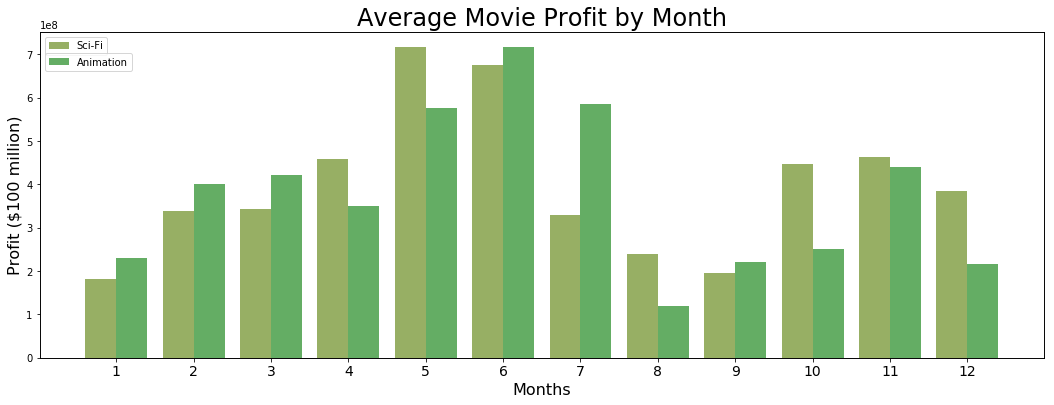

In [34]:
#plot the data

fig, ax = plt.subplots(figsize = (18,6))

#set twin x axis for double bar graph
ax2 = ax.twinx()
#set bar width
width = 0.4

#set genres to get data, this can be any 2 genres in the dataset
genres = ["Sci-Fi", "Animation"]

#-----------------------------------First Subplot---------------------------------------#
#first bar data
axdata = season_profit[(season_profit["genre1"].isin([genres[0]])) | 
              (season_profit["genre2"].isin([genres[0]])) | 
              (season_profit["genre3"].isin([genres[0]])) ].groupby("release_month"
                                                                  ).mean()["worldwide_gross"]

#set first bar data and xposition
ax_xtick = axdata.index
ax_yheight = axdata.values
xpos = np.array(range(0,len(ax_xtick)))

#plot first bar
ax.bar(xpos-width/2,ax_yheight,width=width, label=genres[0], color = "olivedrab", alpha = 0.7)

#set first bar x tick marks and its position
ax.set_xticks(xpos)
ax.set_xticklabels(ax_xtick, size=14)

#prettify first bar
ax.legend(loc="upper left")
ax.set_ylabel("Profit ($100 million)", size=16)
ax.set_xlabel("Months", size=16)

#-----------------------------------Second Subplot---------------------------------------#
#second bar data
ax2data = season_profit[(season_profit["genre1"].isin([genres[1]])) | 
              (season_profit["genre2"].isin([genres[1]])) | 
              (season_profit["genre3"].isin([genres[1]])) ].groupby("release_month"
                                                                  ).mean()["worldwide_gross"]

#set second bar data and xposition
ax2_xtick = ax2data.index
ax2_yheight = ax2data.values
xpos = np.array(range(0,len(ax2_xtick)))

#plot second bar
ax2.bar(xpos+width/2,ax2_yheight, width=width, label=genres[1], color="forestgreen", alpha = 0.7)

#set second bar x tick marks and its position
ax2.set_xticks(xpos)
ax2.set_xticklabels(ax2_xtick, size=14)



#set second legend
ax2.legend(bbox_to_anchor=(0,-0.05,1,1),loc="upper left")
ax2.set_yticks([])

plt.title("Average Movie Profit by Month", size = 24)

#uncomment to save
#plt.savefig("images/avg_month_profit.png")

plt.show()

For `Sci-Fi` and `Animation` May-July seems to be the best moneth to release the title. `Sci-Fi` tends to trail-off quickly during this period, but `Animation` stays strong throught the season. The title should not be targetted for release in the beginning of the year or in august due to it's proven poor record. 